# Sentiment analysis( Text Classification)
https://towardsdatascience.com/a-beginners-guide-to-text-classification-with-scikit-learn-632357e16f3a

In this simple guide, we’re going to create a machine learning model that will predict whether a movie review is positive or negative. This is known as binary text classification and will help us explore the scikit-learn library while building a basic machine learning model from scratch. These are the topics we’re going to learn in this guide.

Table of Contents
1. The Dataset and The Problem to Solve
2. Preparing The Data
 - Reading the dataset
 - Dealing with Imbalanced Classes
 - Splitting data into train and test set
3. Text Representation (Bag of Words)
 - CountVectorizer
 - Term Frequency, Inverse Document Frequency (TF-IDF)
 - Turning our text data into numerical vectors
4. Model Selection
 - Supervised vs Unsupervised learning
 - Support Vector Machines (SVM)
 - Decision Tree
 - Naive Bayes
 - Logistic Regression
5. Model Evaluation
 - Mean Accuracy
 - F1 Score
 - Classification report
 - Confusion Matrix
6. Tuning the Model
 - GridSearchCV

## The Dataset and The Problem to Solve
we’ll use an IMDB dataset of 50k movie reviews available on Kaggle. The dataset contains 2 columns (review and sentiment) that will help us identify whether a review is positive or negative.
https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
<b>Problem formulation:</b> Our goal is to find which machine learning model is best suited to predict sentiment (output) given a movie review (input).

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline 
df_review = pd.read_csv('IMDB Dataset.csv')
df_review

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


This dataset contains 50000 rows; however, to train our model faster in the following steps, we’re going to take a smaller sample of 10000 rows. This small sample will contain 9000 positive and 1000 negative reviews to make the data imbalanced (so I can teach you undersampling and oversampling techniques in the next step)

We’re going to create this small sample with the following code. The name of this imbalanced dataset will bedf_review_imb

In [2]:
df_positive = df_review[df_review['sentiment']=='positive'][:9000]
df_negative = df_review[df_review['sentiment']=='negative'][:1000]
df_review_imb = pd.concat([df_positive, df_negative])

In [3]:
df_review_imb

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
...,...,...
2000,Stranded in Space (1972) MST3K version - a ver...,negative
2005,"I happened to catch this supposed ""horror"" fli...",negative
2007,waste of 1h45 this nasty little film is one to...,negative
2010,Warning: This could spoil your movie. Watch it...,negative


## Dealing with Imbalanced Classes
In most cases, you’ll have a large amount of data for one class, and much fewer observations for other classes. This is known as imbalanced data because the number of observations per class is not equally distributed.
Let’s take a look at how our df_review_imb dataset is distributed.

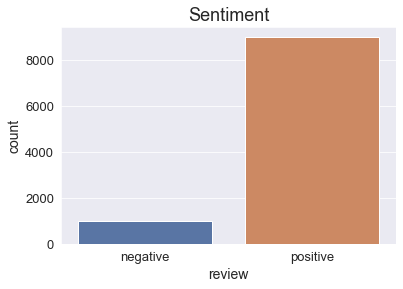

In [4]:
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)  
barplot = df_review_imb.groupby(['sentiment'], as_index=False).count()
ax = sns.barplot(x=barplot['sentiment'], y=barplot['review'], palette='deep',ci=None)
ax.set(title='Sentiment', xlabel='review', ylabel='count')
plt.show()

As we can see there are more positive than negative reviews in df_review_imb so we have imbalanced data.
To resample our data we use the imblearn library. You can either undersample positive reviews or oversample negative reviews (you need to choose based on the data you’re working with). In this case, we’ll use the RandomUnderSampler

In [5]:
!pip install imbalanced-learn
from imblearn.under_sampling import  RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
df_review_bal, df_review_bal['sentiment']=rus.fit_resample(df_review_imb[['review']],
                                                           df_review_imb['sentiment'])
df_review_bal

,review,sentiment
0,Basically there's a family where a little boy ...,negative
1,"This show was an amazing, fresh & innovative i...",negative
2,Encouraged by the positive comments about this...,negative
3,Phil the Alien is one of those quirky films wh...,negative
4,I saw this movie when I was about 12 when it c...,negative
...,...,...
1995,Knute Rockne led an extraordinary life and his...,positive
1996,At the height of the 'Celebrity Big Brother' r...,positive
1997,This is another of Robert Altman's underrated ...,positive
1998,This movie won a special award at Cannes for i...,positive


First, we create a new instance of RandomUnderSampler (rus), we add random_state=0 just to control the randomization of the algorithm. Then we resample the imbalanced dataset df_review_imb by fitting rus with rus.fit_resample(x, y) where “x” contains the data which have to be sampled and “y” corresponds to labels for each sample in “x”.
After this, x and y are balanced and we’ll store it in a new dataset named df_review_bal. We can compare the imbalanced and balanced dataset with the following code.

In [6]:
print(df_review_imb.value_counts('sentiment'))
print(df_review_bal.value_counts('sentiment'))

sentiment
positive    9000
negative    1000
dtype: int64
sentiment
positive    1000
negative    1000
dtype: int64


Clean data before splitting. (already cleaned data)
## Splitting data into train and test set
Before we work with our data, we need to split it into a train and test set. The train dataset will be used to fit the model, while the test dataset will be used to provide an unbiased evaluation of a final model fit on the training dataset.
We’ll use sklearn’s train_test_split to do the job. In this case, we set 33% to the test data.

In [7]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_review_bal, test_size=0.33, random_state=42)

In [8]:
train_x, train_y = train['review'], train['sentiment']
test_x, test_y = test['review'], test['sentiment']

## Text Representation (Bag of Words)
Classifiers and learning algorithms expect numerical feature vectors rather than raw text documents. This is why we need to turn our movie review text into numerical vectors. There are many text representation techniques such as one-hot encoding, bag of words, and wor2vec.

For this simple, we’ll use bag of words (BOW) since we care about the frequency of the words in text reviews; however, the order of words is irrelevant. Two common ways to represent bag of words are CountVectorizer and Term Frequency, Inverse Document Frequency (TF-IDF). Before we choose any of them, I’ll give you an easy-to-understand demonstration of how they work.

### CountVectorizer
The CountVectorizer gives us the frequency of occurrence of words in a document. Let’s consider the following sentences.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
text = ["I love writing code in Python. I love Python code",
        "I hate writing code in Java. I hate Java code"]

df = pd.DataFrame({'review': ['review1', 'review2'], 'text':text})
cv = CountVectorizer(stop_words='english')
cv_matrix = cv.fit_transform(df['text'])
df_dtm = pd.DataFrame(cv_matrix.toarray(), index=df['review'].values, columns=cv.get_feature_names())
df_dtm

,code,hate,java,love,python,writing
review1,2,0,0,2,2,1
review2,2,2,2,0,0,1


As you can see the numbers inside the matrix represent the number of times each word was mentioned in each review. Words like “love,” “hate,” and “code” have the same frequency (2) in this example.
### Term Frequency, Inverse Document Frequency (TF-IDF)
The TF-IDF computes “weights” that represents how important a word is to a document in a collection of documents (aka corpus). The TF-IDF value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word.

The representation with TF-IDF will look like the picture below for the same text we used before.


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
text = ["I love writing code in Python. I love Python code",
        "I hate writing code in Java. I hate Java code"]

df = pd.DataFrame({'review': ['review1', 'review2'], 'text':text})
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['text'])
df_dtm = pd.DataFrame(tfidf_matrix.toarray(), index=df['review'].values, columns=tfidf.get_feature_names())
df_dtm

,code,hate,java,love,python,writing
review1,0.438501,0.000000,0.000000,0.616298,0.616298,0.21925
review2,0.438501,0.616298,0.616298,0.000000,0.000000,0.21925


Unlike, the previous example the word “code” doesn’t have the same weight as the words “love” or “hate.” This happens because “code” appears in both reviews; therefore, its weight decreased.

### Turning our text data into numerical vectors
In our original dataset, we want to identify unique/representative words for positive reviews and negative reviews, so we’ll choose the TF-IDF. To turn text data into numerical vectors with TF-IDF, we write the following code.

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
train_x_vector = tfidf.fit_transform(train_x)
train_x_vector

<1340x20625 sparse matrix of type '<class 'numpy.float64'>'
	with 118834 stored elements in Compressed Sparse Row format>

In the code above, we create a new instance of TfidfVectorizer(tfidf), we removed English stopwords and then fit (finds the internal parameters of a model) and transform (applies the parameters to the data) the train_x (text reviews)

The train_x_vector we just created is a sparse matrix with a shape of 1340 reviews and 20625 words (whole vocabulary used in the reviews). You can display this matrix  with the following code

In [12]:
train_x

81      I just got back from this free screening, and ...
915     Claire Denis's movies seem to fall into one of...
1018    One must admit, that Dev has an eye for beauty...
380     Mario Lewis of the Competitive Enterprise Inst...
1029    The first, and far better, of Kevin Kline's tw...
                              ...                        
1130    I saw the movie in Izmir as the closing film o...
1294    This is a great documentary and above comments...
860     Obviously, the comments above that fawn over t...
1459    Robert Carlyle excels again. The period was ca...
1126    A convict serving time comes forward to give t...
Name: review, Length: 1340, dtype: object

In [13]:
###a_set = set(tfidf.get_feature_names())
#number_of_unique_values = len(a_set)
#print(number_of_unique_values)

In [14]:
pd.DataFrame.sparse.from_spmatrix(train_x_vector,
                                  index=train_x.index,
                                  columns=tfidf.get_feature_names())

,00,000,007,01pm,02,04,08,10,100,1000,...,zooming,zooms,zues,zzzzzzzzzzzzzzzzzz,æon,élan,émigré,ísnt,ïn,ünfaithful
81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.042791,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


the above is the weights of each word(column) in the respective observation

Finally, let's also transform the test_x_vector, so we can test the accuracy of the model later (we don’t need to fit tfidf again since we already did it with the training data.)

In [15]:
test_x_vector = tfidf.transform(test_x)

## Model Selection
In our example, our input (review) and output (sentiment) are clearly identified, so we can say we have labeled input and output data; therefore, we’re dealing with supervised learning.
* Regression: They’re used to predict continuous values such as price, salary, age, etc
* Classification: They’re used to predict discrete values such as male/female, spam/not spam, positive/negative, etc.

### Support Vector Machines (SVM)

In [16]:
#SVM
from sklearn.svm import SVC
svc = SVC(kernel='linear')
svc.fit(train_x_vector, train_y)

SVC(kernel='linear')

In [17]:
print(svc.predict(tfidf.transform(['A good movie'])))
print(svc.predict(tfidf.transform(['An excellent movie'])))
print(svc.predict(tfidf.transform(['I did not like this movie at all'])))

['positive']
['positive']
['negative']


In [18]:
#decision Tree
from sklearn.tree import DecisionTreeClassifier
dec_tree = DecisionTreeClassifier()
dec_tree.fit(train_x_vector, train_y)

DecisionTreeClassifier()

In [19]:
#Naive Bayes
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(train_x_vector.toarray(), train_y)

GaussianNB()

In [20]:
type(train_x_vector.toarray())
#toarray returns an ndarray; todense returns a matrix. If you want a matrix, use todense; otherwise, use toarray

numpy.ndarray

In [21]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(train_x_vector, train_y)

LogisticRegression()

## Model Evaluation
In this section, we’ll see traditional metrics used to evaluate our models.
### Mean Accuracy
To obtain the mean accuracy of each model, just use the .score method with the test samples and true labels as shown below.

In [22]:
# svc.score('Test samples', 'True labels')
print(svc.score(test_x_vector, test_y))
print(dec_tree.score(test_x_vector, test_y))
print(gnb.score(test_x_vector.toarray(), test_y))
print(log_reg.score(test_x_vector, test_y))

0.8409090909090909
0.6530303030303031
0.6348484848484849
0.8303030303030303


SVM and Logistic Regression perform better than the other two classifiers, with SVM having a slight advantage (84% of accuracy). To show how the other metrics work, we’ll focus only on SVM.
###  F1 Score
F1 Score is the weighted average of Precision and Recall. Accuracy is used when the True Positives and True negatives are more important while F1-score is used when the False Negatives and False Positives are crucial. Also, F1 takes into account how the data is distributed, so it’s useful when you have data with imbalance classes.

```python
F1 Score = 2*(Recall * Precision) / (Recall + Precision)
# F1 score reaches its best value at 1 and worst score at 0.
f1_score(y_true, y_pred)
```

In [23]:
from sklearn.metrics import f1_score
f1_score(test_y, svc.predict(test_x_vector),
         labels=['positive', 'negative'],
         average=None)

array([0.84671533, 0.83464567])

To obtain the F1 score, we need the true labels and predicted labelsf1_score(y_true, y_pred)

The scores obtained for positive labels is 0.84, while negative labels is 0.83.
### Classification report
We can also build a text report showing the main classification metrics that include those calculated before. To obtain the classification report, we need the true labels and predicted labels classification_report(y_true, y_pred)

In [24]:
from sklearn.metrics import classification_report
print(classification_report(test_y, 
                            svc.predict(test_x_vector),
                            labels=['positive', 'negative']))

              precision    recall  f1-score   support

    positive       0.83      0.87      0.85       335
    negative       0.85      0.82      0.83       325

    accuracy                           0.84       660
   macro avg       0.84      0.84      0.84       660
weighted avg       0.84      0.84      0.84       660



A confusion matrix is a table that allows visualization of the performance of an algorithm. This table typically has two rows and two columns that report the number of false positives, false negatives, true positives, and true negatives.

To obtain the confusion matrix, we need the true labels and predicted labels.

In [25]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(test_y, 
                            svc.predict(test_x_vector), 
                            labels=['positive', 'negative'])
conf_mat

array([[290,  45],
       [ 60, 265]], dtype=int64)

As you can see, each element of the array represents one of the four squares in the confusion matrix (e.g., our model detected 290 true positives)
## Tuning the Model
Finally, it’s time to maximize our model’s performance.
### GridSearchCV
This is technique consists of an exhaustive search on specified parameters in order to obtain the optimum values of hyperparameters. To do so, we write the following code.

In [26]:
from sklearn.model_selection import GridSearchCV
#set the parameters
parameters = {'C': [1,4,8,16,32] ,'kernel':['linear', 'rbf']}
svc = SVC()
svc_grid = GridSearchCV(svc,parameters, cv=5)

svc_grid.fit(train_x_vector, train_y)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 4, 8, 16, 32], 'kernel': ['linear', 'rbf']})

As you can see the code it’s not so different from the one we wrote to fit the SVM model; however, now we specified some parameters to obtain the optimum model.

After fitting the model, we obtain the best score, parameters, and estimators with the following code.

In [27]:
print(svc_grid.best_params_)
print(svc_grid.best_estimator_)

{'C': 1, 'kernel': 'linear'}
SVC(C=1, kernel='linear')
